In [1]:
# from tkinter.messagebox import YES
import control as ctl
import matplotlib.pyplot as plt
import time

In [48]:
class PID():
    
    # --e(t)-->[PID Controller]--(u(t))-->[Plant]--(y(t))-->
    
    def __init__(self, kp: float, ki: float, kd: float, ts: float) -> None:
        
        self._Kp = kp
        self._Ki = ki
        self._Kd = kd
        self._Ts = ts   ## 采样间隔
        
    def process(self, et: list[list[float]], y: list[float], u: list[float], is_expert=False):
        
        ## et: error table
        
        # DBG: print(et) if (len(et) < 10) else ...
        
        print(f'inloop, et = {et[-1]}, Kp = {self._Kp}, Ki = {self._Ki}, Kd = {self._Kd}')
        
        output_u = self._Kp * et[-1][0] + self._Ki * et[-1][1] + self._Kd * et[-1][2]
        
        print(output_u)
        
        if is_expert:
            ## Expert PID Controller

            ## Rule 1. Open-loop
            if abs(et[-1][0]) > 0.8:
                output_u = 0.45
            elif (abs(et[-1][0])>0.40):        
                output_u = 0.40
            elif (abs(et[-1][0])>0.20): 
                output_u = 0.12
            elif (abs(et[-1][0])>0.01):
                output_u = 0.10
                    
            ## Rule 2. 
            if (et[-1][0] * et[-1][2] > 0) or (et[-1][2] == 0):
                if abs(et[-1][0]) >= 0.05:
                    output_u = u[-1] + 2*self._Kp*et[-1][0]
                else:
                    output_u = u[-1] + 0.4*self._Kp*et[-1][0]
            
            ## Rule 3.
            if (et[-1][0] * et[-1][2] < 0 and et[-1][2] * et[-2][2] > 0) or (et[-1][0] == 0):
                ...
                # output_u = self._Kp*et[-1][0] + self._Ki*et[-1][1] + self._Kd*et[-1][2]
                
            ## Rule 4.
            if et[-1][0] * et[-1][2] < 0 and et[-1][2] * et[-2][2] < 0:
                if abs(et[-1][0] >= 0.05):
                    output_u = u[-1] + 2*self._Kp*et[-1][0]
                else:
                    output_u = u[-1] + 0.6*self._Kp*et[-1][0]
                    
            ## Rule 5.
            if abs(et[-1][0] <= 0.001):
                output_u = 0.5*et[-1][0] + 0.010*et[-1][1]
            
            # output_u = 10 if output_u >= 10 else output_u
            # output_u = -10 if output_u <= -10 else output_u
            
        if output_u >= 10:
            output_u = 10
        if output_u <= -10:
            output_u = -10
            
        print(f'now u = {output_u}')
        
        return output_u

YES
inloop, et = [0, 0, 0], Kp = 0.6, Ki = 0.03, Kd = 0.01
0.0
now u = 0.0
endloop: [1.0, 0.001, 1000.0], 0.0
inloop, et = [1.0, 0.001, 1000.0], Kp = 0.6, Ki = 0.03, Kd = 0.01
10.60003
now u = 10
endloop: [1.0, 0.002, 0.0], 10
inloop, et = [1.0, 0.002, 0.0], Kp = 0.6, Ki = 0.03, Kd = 0.01
0.6000599999999999
now u = 10
endloop: [0.999146668734844, 0.002999146668734844, -0.8533312651559655], 10
inloop, et = [0.999146668734844, 0.002999146668734844, -0.8533312651559655], Kp = 0.6, Ki = 0.03, Kd = 0.01
0.5910446629894088
now u = 0.45
endloop: [0.9933282848352384, 0.0039924749535700825, -5.81838389960565], 0.45
inloop, et = [0.9933282848352384, 0.0039924749535700825, -5.81838389960565], Kp = 0.6, Ki = 0.03, Kd = 0.01
0.5379329061536936
now u = 0.5379329061536936
endloop: [0.9788248537133278, 0.0049712998072834105, -14.503431121910548], 0.5379329061536936
inloop, et = [0.9788248537133278, 0.0049712998072834105, -14.503431121910548], Kp = 0.6, Ki = 0.03, Kd = 0.01
0.44240974000310973
now u = 

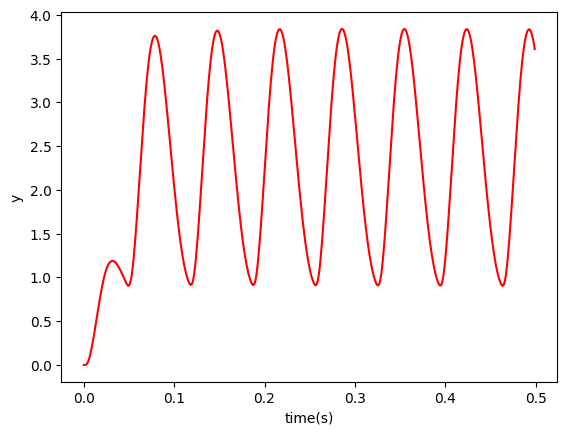

In [46]:
# def test(kp, kd, ki, ts):

kp=0.6
ki=0.03
kd=0.01
ts=0.001

if 1 == 1:
    
    print('YES')
    
    sys = ctl.tf([523500], [1, 87.35, 10470, 0])
    dsys = ctl.c2d(sys, ts, 'zoh')
    [num, den] = ctl.tfdata(dsys)
    
    pid = PID(kp, ki, kd, ts)
    
    y = [0,0,0]
    u = [0,0,0]
    
    times = [0,0,0]
    
    et = [[0,0,0], [0,0,0], [0,0,0]]
    
    st_point = 1.0
    
    for i in range(500):
        
        u_new = pid.process(et, y, u, True)
        
        y_new = -den[0][0][1]*y[-1]-den[0][0][2]*y[-2]-den[0][0][3]*y[-3]\
                +num[0][0][0]*u[-1]+num[0][0][1]*u[-2]+num[0][0][2]*u[-3]
        
        error = st_point - y_new
        
        tmp_errs = [error, et[-1][1]+error*ts, (error-et[-1][0])/ts]
        
        et.append(tmp_errs)
        u.append(u_new)
        y.append(y_new)
        times.append(i*ts)
        
        print(f'endloop: {tmp_errs}, {u[-1]}')
    
    # plt.figure(1)
    
    err = []
    
    for item in et:
        err.append(item[0])
        
    
    plt.plot(times,y,'r')
    plt.xlabel('time(s)');plt.ylabel('y')
    plt.show()

In [30]:
y

[0,
 0,
 0,
 0.0,
 0.0,
 0.0026111945247085195,
 0.01785546213374918,
 0.047267703277375464,
 0.08960214565170176,
 0.14341390541971122,
 0.20704925413437986,
 0.2786881959760916,
 0.3563949272383421,
 0.4381687355831548,
 0.5219943101685418,
 0.6058903026566992,
 0.6879550562026464,
 0.7664085327113271,
 0.8396295995204499,
 0.9061879820096048,
 0.9648703444196362,
 1.014700123247113,
 1.0549509018391858,
 1.0851532772561325,
 1.1050953273043365,
 1.1148169333744453,
 1.1145983502134094,
 1.1049435343021694,
 1.0865588458587851,
 1.0603278238981813,
 1.0272827980358445,
 0.9885741441353769,
 0.945438013304906,
 0.8991633654876232,
 0.8510591207870646,
 0.8024222049759362,
 0.7545072120058051,
 0.7084983377455423,
 0.665484157883979,
 0.6264357313999253,
 0.5921884118345283,
 0.5634276444740312,
 0.540678921148826,
 0.5243019583030437,
 0.5144890607957623,
 0.5112675358957164,
 0.5145059312407225,
 0.5239237890034899,
 0.5391045376945381,
 0.5595110841781888,
 0.5845036224806499,
 0.61

In [15]:
sys = ctl.tf([523500], [1, 87.35, 10470, 0])
dsys = ctl.c2d(sys, ts, 'zoh')
print(sys)
print(dsys)
[num, den] = ctl.tfdata(dsys)
print(num)
print(den)


          5.235e+05
-----------------------------
s^3 + 87.35 s^2 + 1.047e+04 s


8.533e-05 z^2 + 0.0003338 z + 8.169e-05
---------------------------------------
  z^3 - 2.906 z^2 + 2.823 z - 0.9164

dt = 0.001

[[array([8.53331265e-05, 3.33831370e-04, 8.16859077e-05])]]
[[array([ 1.        , -2.90633931,  2.82269562, -0.91635631])]]
